# Dimensionality reduction on mouse types


In [58]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

In [59]:
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
functions_path = '/home/ines/repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
os.chdir(functions_path)
states_trial_type = pd.read_pickle("./states_trial_type_new.pkl")
extended = pd.read_pickle("./mouse_movements_df.pkl")
extended_short = extended[['trial_id', 'Bin', 'session', 'virtual_response', 'ballistic']]

In [60]:
merged = states_trial_type.merge(extended_short, on=['trial_id', 'Bin', 'session']).drop_duplicates()


## Extend states

In [62]:
extended_states = merged.copy()
extended_states['ori_states'] = extended_states['identifiable_states'].copy()

# New wheel states
# Wheel movement, no response
move_no_resp = extended_states.loc[(extended_states['virtual_response'].isna()) &
                                   (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response'].isna()) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'n' + move_no_resp.str[1:]
# Response L, non ballistic
left_non_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                         (extended_states['ballistic']==False) &
                                         (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'l' + left_non_ballistic.str[1:]
# Response R, non ballistic
right_non_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                          (extended_states['ballistic']==False) &
                                          (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'r' + right_non_ballistic.str[1:]

# Response L, ballistic
left_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                     (extended_states['ballistic']==True) &
                                     (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'L' + left_ballistic.str[1:]

# Response R, non ballistic
right_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                      (extended_states['ballistic']==True) &
                                      (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'R' + right_ballistic.str[1:]


## Parameters

In [63]:
bin_size = 0.1
multiplier = 1/bin_size

In [64]:
states_trial_type = extended_states.copy()
# states_trial_type = merged.copy()

In [65]:
def groupby(vars, use_data):
    # Step 1: Group and count occurrences
    count = pd.DataFrame(use_data.groupby(vars)['identifiable_states'].count())  #  'correct',

    # Step 2: Reset index to bring the grouping columns back into the DataFrame
    count = count.reset_index(level=list(np.arange(0, len(vars)-1, 1)))

    # Rename the count column
    count.rename(columns={'identifiable_states': 'count'}, inplace=True)

    # Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'

    # Step 4: Compute the relative frequency
    count['relative_frequency'] = count['count'] / count['total']

    # Drop the 'total' column if it's no longer needed
    count = count.drop(columns=['total'])

    return count


In [66]:
# Fix wrong string in wsls
states_trial_type.loc[states_trial_type['wsls']=='ls', 'wsls'] = 'lst'

# Compute features and organize sample keys

In [68]:
trial_type_agg = ['wsls', 'correct_str', 'choice', 'contrast_str']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice', 'virtual_response', 'ballistic']
# trial_type_agg = ['correct_str', 'contrast_str', 'wsls']
# trial_type_agg = ['correct_str', 'perseverence']
# trial_type_agg = ['wsls']
# trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice', 'virtual_response', 'ballistic']
trial_type_agg = ['correct_str', 'contrast_type']
# trial_type_agg = ['correct_str', 'contrast_str', 'wsls']


order_0 = ['left', 'right']
order_1 = ['correct', 'incorrect']
order_1_1 = ['1.0',
    '0.25', 
    '0.125', 
    '0.0625', 
    '0.0']
order_1_2 = ['wst',
    'lst', 
    'wsh', 
    'lsh']


order_2 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 1.0', 
    'incorrect 0.25', 
    'incorrect 0.125', 
    'incorrect 0.0625', 
    'incorrect 0.0']
order_2_1 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 0.0', 
    'incorrect 0.0625', 
    'incorrect 0.125', 
    'incorrect 0.25', 
    'incorrect 1.0']

order_2_2 = ['correct high',
    'correct low', 
    'incorrect high', 
    'incorrect low']

order_3 = ['correct 1.0 left', 'correct 1.0 right', 
    'correct 0.25 left', 'correct 0.25 right',
    'correct 0.125 left', 'correct 0.125 right',
    'correct 0.0625 left', 'correct 0.0625 right',
    'correct 0.0 left', 'correct 0.0 right',
    'incorrect 1.0 left', 'incorrect 1.0 right', 
    'incorrect 0.25 left', 'incorrect 0.25 right',
    'incorrect 0.125 left', 'incorrect 0.125 right',
    'incorrect 0.0625 left', 'incorrect 0.0625 right',
    'incorrect 0.0 left', 'incorrect 0.0 right']

order_4 = ['correct 1.0 wst', 'correct 1.0 wsh', 'correct 1.0 lst', 'correct 1.0 lsh', 
    'correct 0.25 wst', 'correct 0.25 wsh', 'correct 0.25 lst', 'correct 0.25 lsh', 
    'correct 0.125 wst', 'correct 0.125 wsh', 'correct 0.125 lst', 'correct 0.125 lsh',
    'correct 0.0625 wst', 'correct 0.0625 wsh',   'correct 0.0625 lst', 'correct 0.0625 lsh',
    'correct 0.0 wst', 'correct 0.0 wsh', 'correct 0.0 lst', 'correct 0.0 lsh',
    'incorrect 1.0 wst', 'incorrect 1.0 wsh',  'incorrect 1.0 lst', 'incorrect 1.0 lsh', 
    'incorrect 0.25 wst', 'incorrect 0.25 wsh', 'incorrect 0.25 lst', 'incorrect 0.25 lsh',
    'incorrect 0.125 wst', 'incorrect 0.125 wsh', 'incorrect 0.125 lst', 'incorrect 0.125 lsh',
    'incorrect 0.0625 wst', 'incorrect 0.0625 wsh',  'incorrect 0.0625 lst', 'incorrect 0.0625 lsh',
    'incorrect 0.0 wst', 'incorrect 0.0 wsh', 'incorrect 0.0 lst', 'incorrect 0.0 lsh']

order_5 = ['correct wst', 'correct lst', 'correct wsh', 'correct lsh',
    'incorrect wst', 'incorrect lst',  'incorrect wsh', 'incorrect lsh']

order_6 = ['correct stay', 'correct shift',
    'incorrect stay', 'incorrect shift']

use_order = order_2_2

In [69]:
""" Define trial types"""
states_trial_type['correct_str'] = states_trial_type['correct']
states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
states_trial_type.loc[states_trial_type['correct_str']==0., 'correct_str'] = 'incorrect'
states_trial_type['contrast_type'] = states_trial_type['contrast']
states_trial_type.loc[states_trial_type['contrast']>=.25, 'contrast_type'] = 'high'
states_trial_type.loc[states_trial_type['contrast']<.25, 'contrast_type'] = 'low'

states_trial_type['contrast_str'] = states_trial_type['contrast'].astype(str)
states_trial_type['perseverence'] = states_trial_type['wsls'].copy()
states_trial_type.loc[states_trial_type['wsls'].isin(['wst', 'lst']), 'perseverence']  = 'stay'
states_trial_type.loc[states_trial_type['wsls'].isin(['wsh', 'lsh']), 'perseverence']  = 'shift'
states_trial_type.loc[states_trial_type['ballistic']==True, 'ballistic'] = 1
states_trial_type.loc[states_trial_type['ballistic']==False, 'ballistic'] = 0
states_trial_type['trial_type'] = states_trial_type[trial_type_agg].agg(' '.join, axis=1)
states_trial_type['trial_str'] = states_trial_type['trial_id'].astype(str)
states_trial_type['sample'] = states_trial_type[['session']].agg(' '.join, axis=1)

""" Frequency """
vars = ['sample', 'trial_type', 'broader_label', 'mouse_name']
extended_vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'identifiable_states']
count = groupby(extended_vars, states_trial_type)

# Pivot the DataFrame
freq_df = count.reset_index().pivot(index=['sample', 'mouse_name'], columns=['trial_type', 'identifiable_states', 'broader_label'], values='relative_frequency')
# To flatten the column MultiIndex
freq_df.columns = ['_'.join(col).strip() for col in freq_df.columns.values]
freq_df[freq_df.isna()] = 0

# """ Timings """
# times = pd.DataFrame(states_trial_type.groupby(['sample', 'trial_type', 'mouse_name'])['reaction', 'response', 'elongation'].mean()).reset_index()

""" Original states and wheel states """
ballistic = pd.DataFrame(states_trial_type.groupby(['sample', 'mouse_name'])['ballistic'].mean()).reset_index()
virtual_resp = pd.DataFrame(states_trial_type.groupby(['sample', 'mouse_name'])['virtual_response'].mean()).reset_index()

# Merge
merged_df = freq_df.merge(ballistic, on=['sample', 'mouse_name'])
merged_df = merged_df.merge(virtual_resp, on=['sample', 'mouse_name'])


## Prepare design matrix

In [35]:
var_names = merged_df.keys()[2:-2]
len(var_names)

per_mouse = pd.DataFrame(merged_df.groupby(['mouse_name'])[var_names].mean()).reset_index()

ori_X = np.array(per_mouse[var_names]) 
print(np.shape(ori_X))


(51, 451)


## UMAP

In [36]:
reducer = umap.UMAP(random_state= 42, n_components=2)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(ori_X)

# embedding = reducer.fit_transform(standardized_X)
# embedding.shape

embedding = reducer.fit_transform(ori_X)
embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(51, 2)

In [37]:
# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(per_mouse['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(per_mouse['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = per_mouse['mouse_name'].map(map_mouse_names)

Text(0, 0.5, 'UMAP 2')

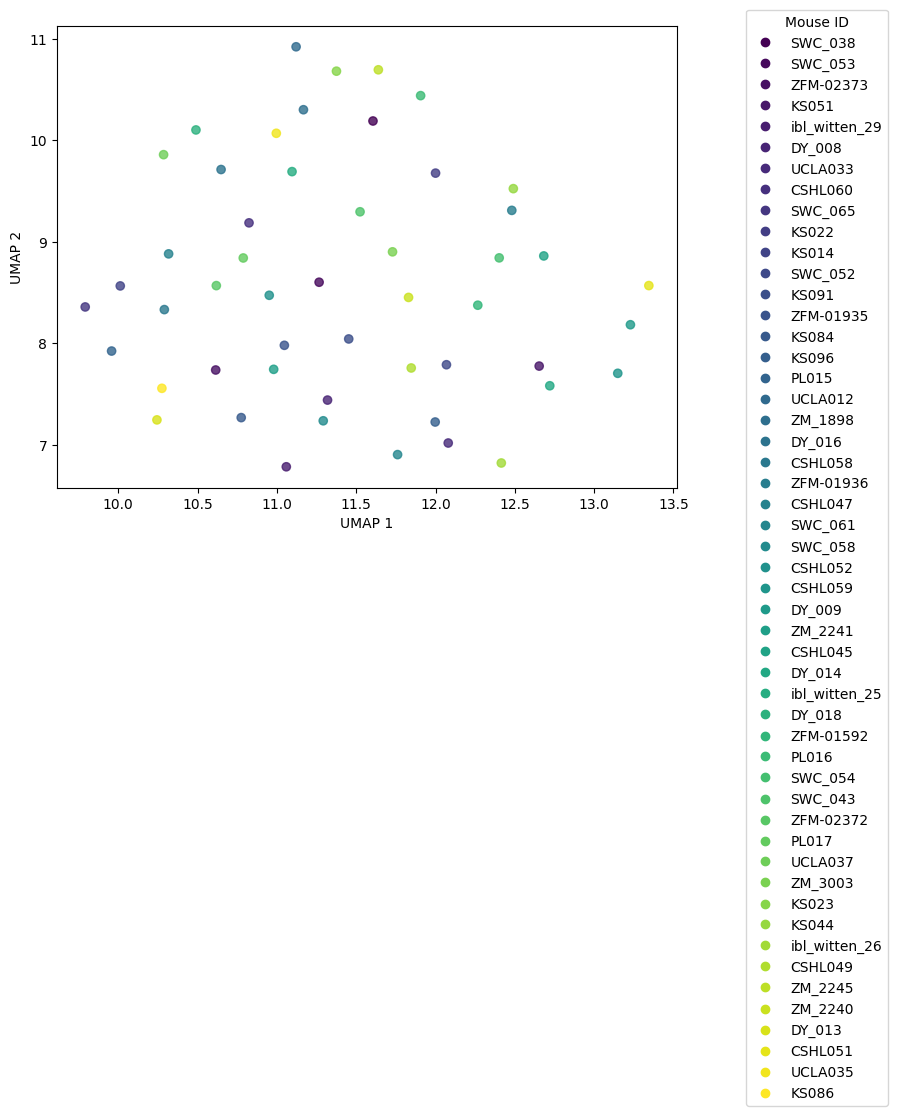

In [38]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding[:, 0][0:],
    embedding[:, 1][0:],
    alpha=0.8,
    c=mouse_name_numbers[0:],
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], merged_df['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# unique_mouse_labels = np.arange(0, len(merged_df['mouse_name'].unique()), 1)
# map_mouse_names = dict(zip(merged_df['mouse_name'].unique(), unique_mouse_labels))
# mouse_name_numbers = merged_df['mouse_name'].map(map_mouse_names)


# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')


## K-means clustering of data

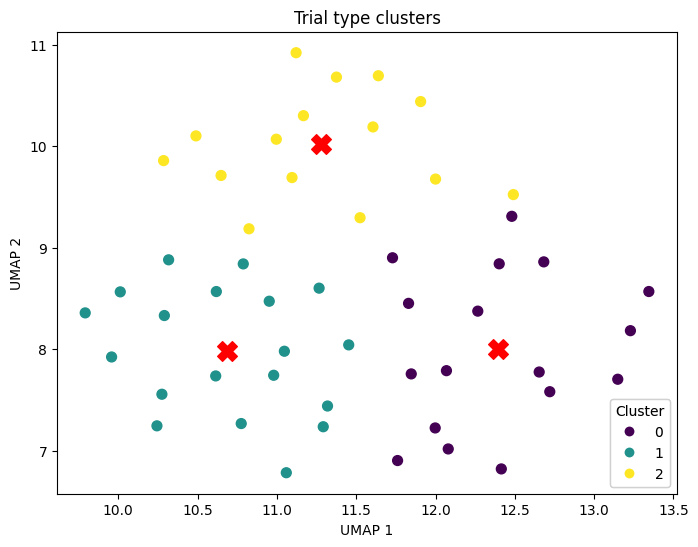

In [40]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans = KMeans(n_clusters=3, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centroids = kmeans.cluster_centers_
dots = ax.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")
ax.add_artist(legend1)

plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [42]:
per_mouse['cluster'] = y_kmeans
cluster_info = per_mouse[['mouse_name', 'cluster']]

In [46]:
# Analyze state features
merged_df = merged_df.merge(cluster_info, on=['mouse_name'])
df_cluster = count.reset_index().merge(merged_df[['sample', 'cluster']], on='sample')
# df_cluster = df_cluster.merge(sum[['sample', 'broader_label', 'sum']], on=['sample', 'broader_label'])
df_cluster = df_cluster.merge(states_trial_type[['sample', 'reaction', 'response', 'elongation', 'perseverence', 
                                                 'choice', 'contrast', 'wsls', 'correct']].drop_duplicates(), on=['sample'])
df_cluster = df_cluster.merge(ballistic[['sample', 'ballistic']], on=['sample'])


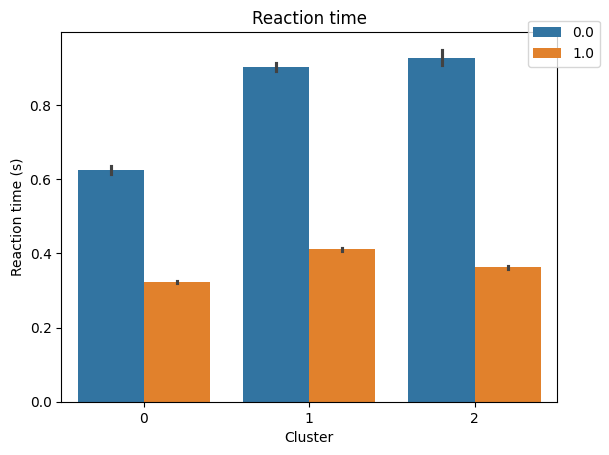

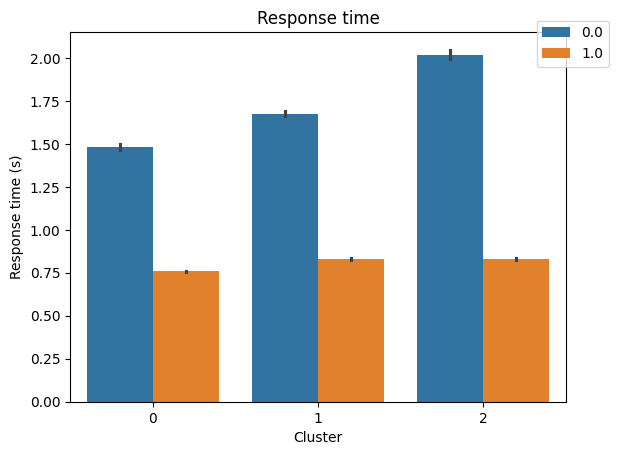

In [48]:
sns.barplot(x='cluster', y='reaction', hue='correct', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='response', hue='correct', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.xlabel('Cluster')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


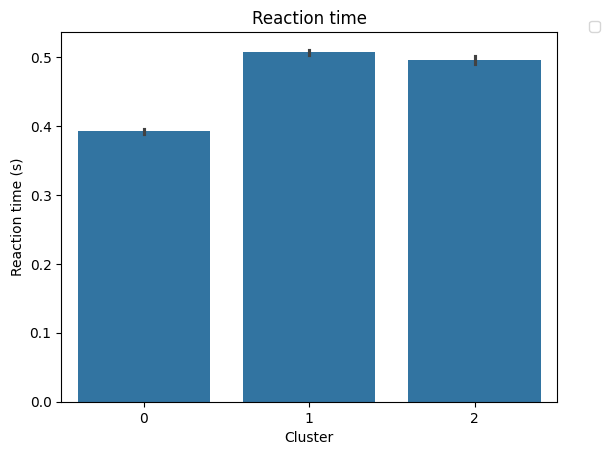

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


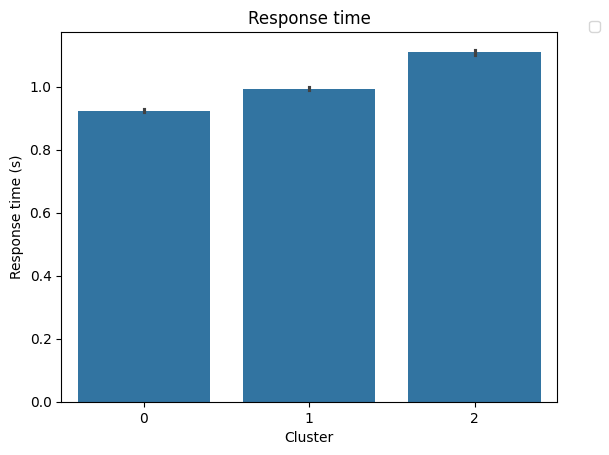

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


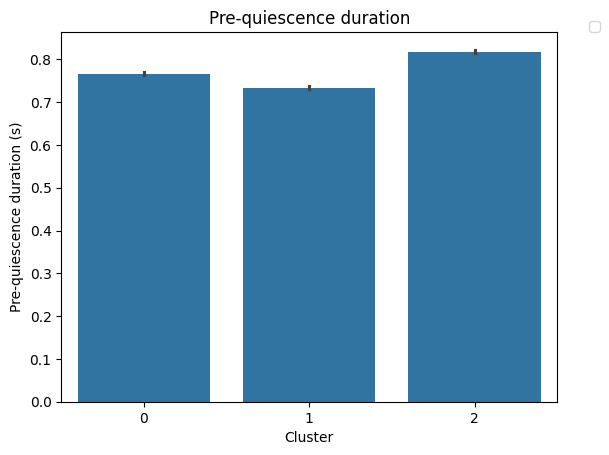

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


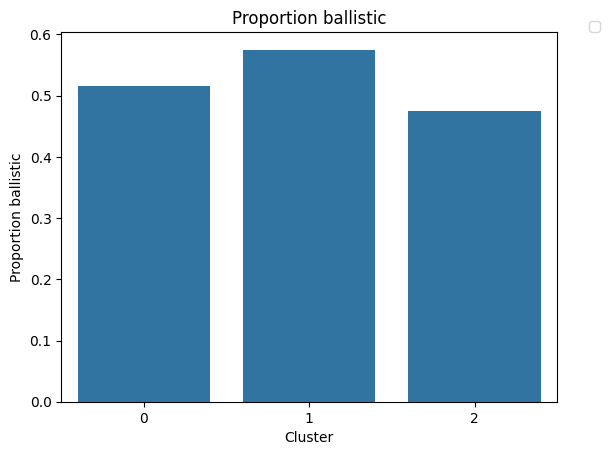

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


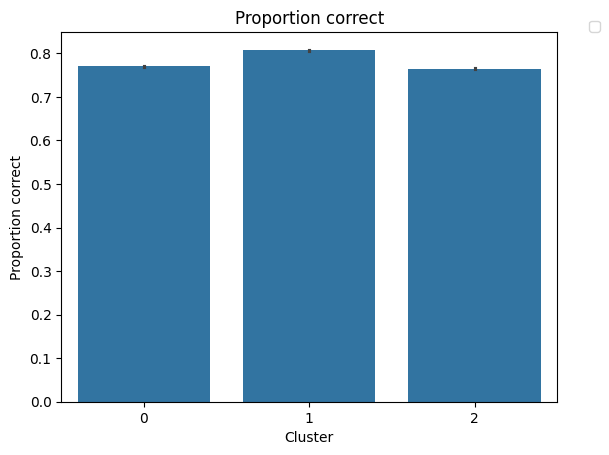

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


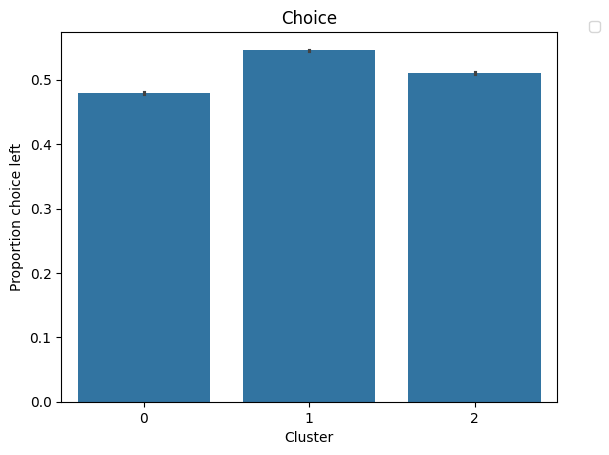

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


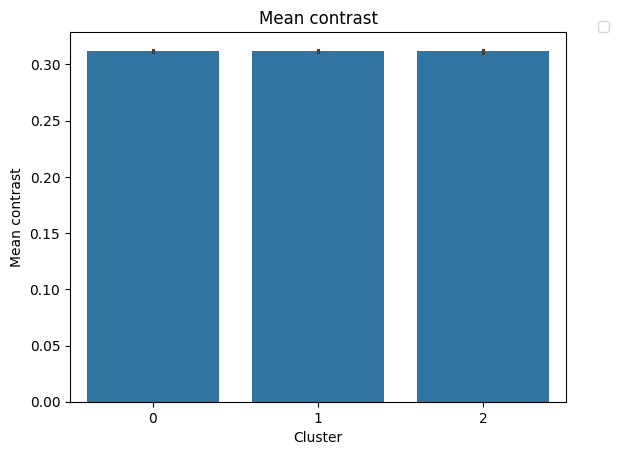

In [49]:
sns.barplot(x='cluster', y='reaction', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='response', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='elongation', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='ballistic', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='correct', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.xlabel('Cluster')
# plt.ylim([.6, .9])
plt.show()

use_data = df_cluster.copy()
use_data.loc[use_data['choice']=='left', 'choice'] = 1
use_data.loc[use_data['choice']=='right', 'choice'] = 0
sns.barplot(x='cluster', y='choice', data=use_data)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Choice')
plt.ylabel('Proportion choice left')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='contrast', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Mean contrast')
plt.ylabel('Mean contrast')
plt.xlabel('Cluster')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


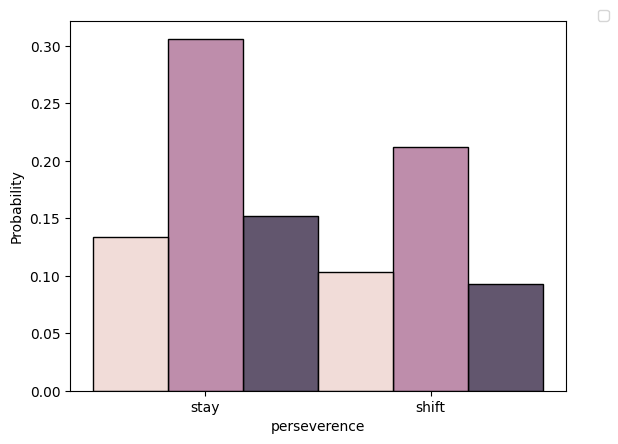

In [ ]:
sns.histplot(x='perseverence', hue='cluster', data=df_cluster, stat='probability', multiple='dodge')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('')
plt.show()


In [ ]:
def revert_to_original(use_data):
    # Revert to original states
    use_data['original_states'] = use_data['identifiable_states'].copy()

    state = use_data.loc[use_data['original_states'].str[0]=='L', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='L', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='l', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='l', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='R', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='R', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='r', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='r', 'original_states'] = '1' + state.str[1:]


    state = use_data.loc[use_data['original_states'].str[0]=='n', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='n', 'original_states'] = '1' + state.str[1:]
    
    return use_data

def get_ballistic(use_data):
    use_data['bal_state'] = use_data['identifiable_states'].copy()
    use_data.loc[use_data['identifiable_states'].str[0]=='L', 'bal_state'] = 'balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='R', 'bal_state'] = 'balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='l', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='r', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='n', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='0', 'bal_state'] = np.nan

    return use_data

/tmp/ipykernel_8584/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


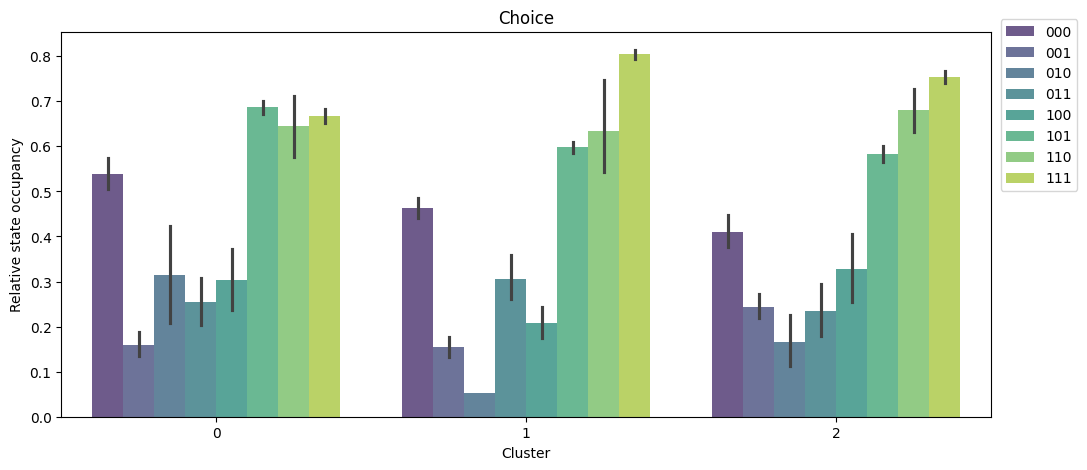

/tmp/ipykernel_8584/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


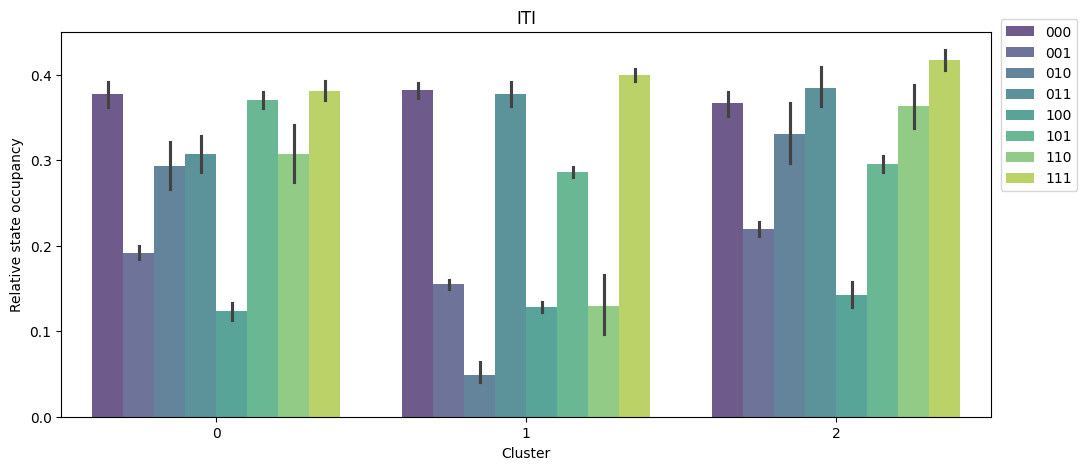

/tmp/ipykernel_8584/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


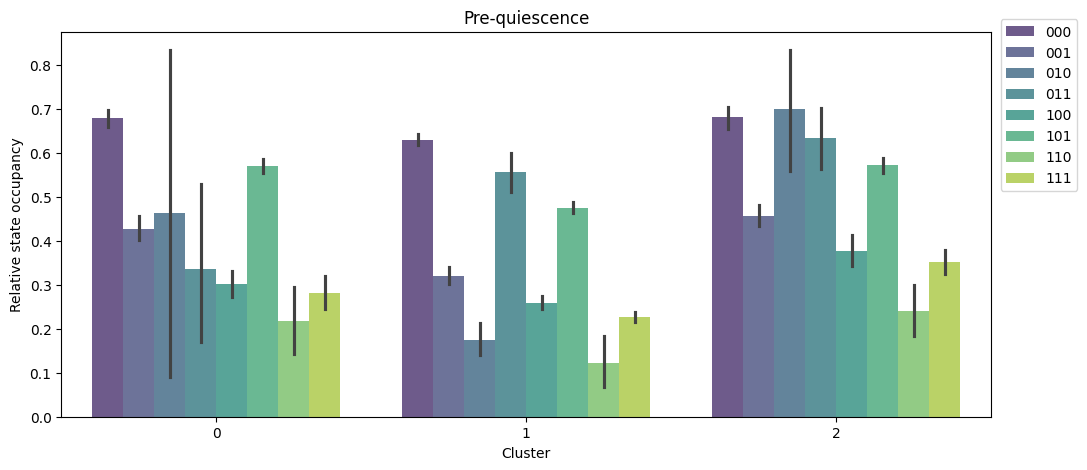

/tmp/ipykernel_8584/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


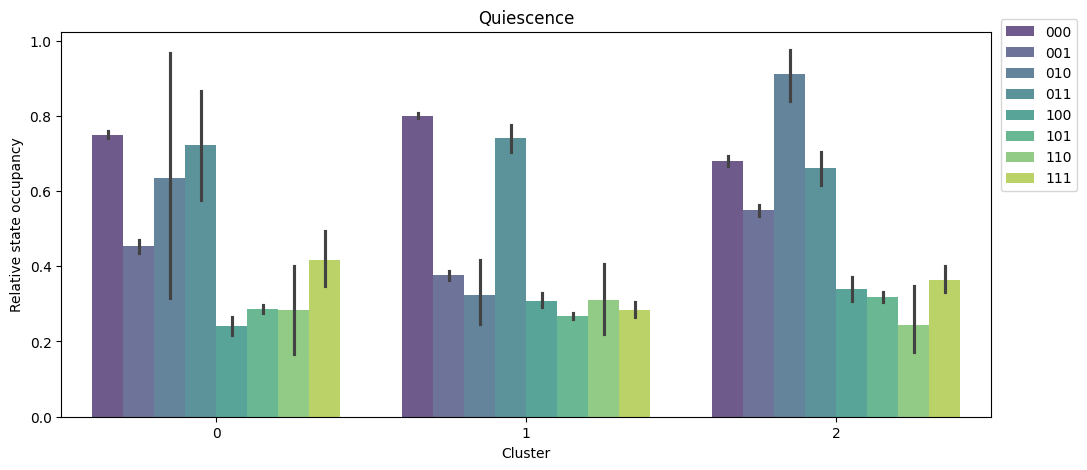

/tmp/ipykernel_8584/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


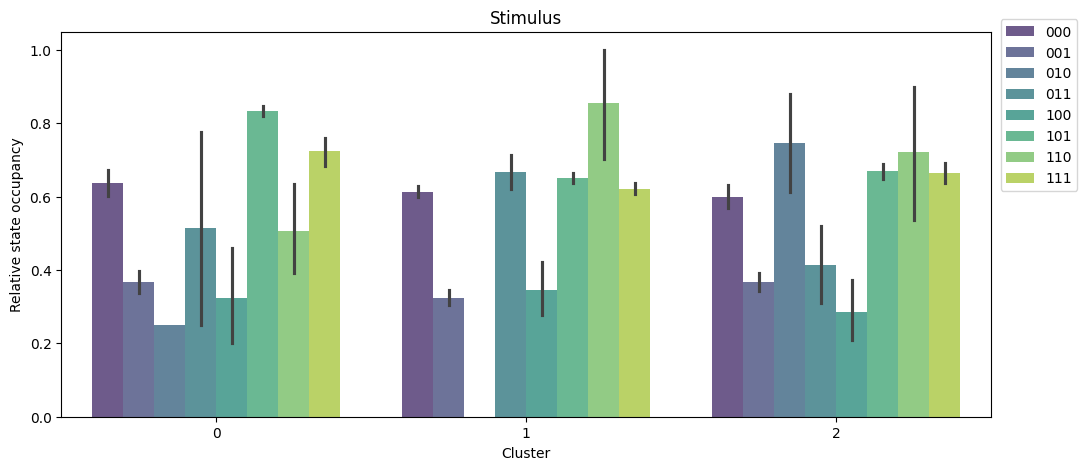

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    use_data = revert_to_original(use_data)
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(hue='original_states', y='relative_frequency', x='cluster', alpha=0.8,
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Cluster')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

## Plot ballistic stats per cluster

ValueError: Could not interpret value `ballistic` for `hue`. An entry with this name does not appear in `data`.

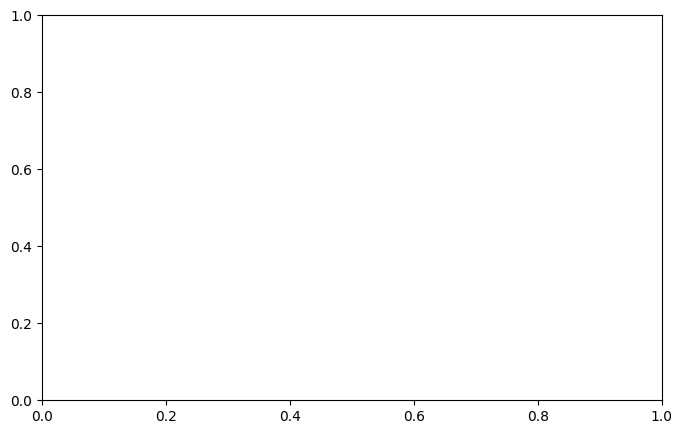

In [ ]:

labels = ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']
colors = sns.color_palette('tab10')[0:2]
count['broader_label'] = pd.Categorical(count['broader_label'], categories=labels)
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(x='broader_label', y='count', data=count, hue='ballistic')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')
# plt.xticks(rotation=45, ha='right')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
# except:

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


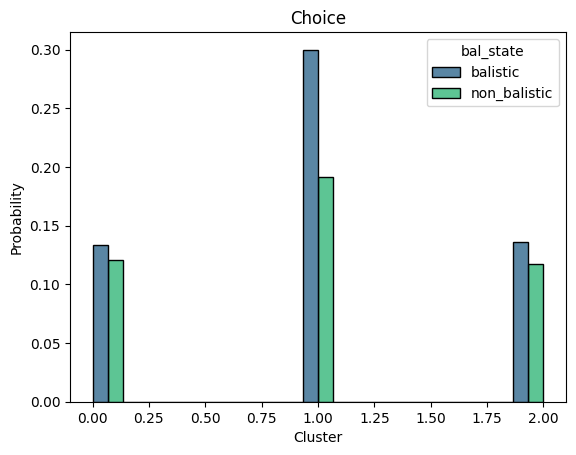

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


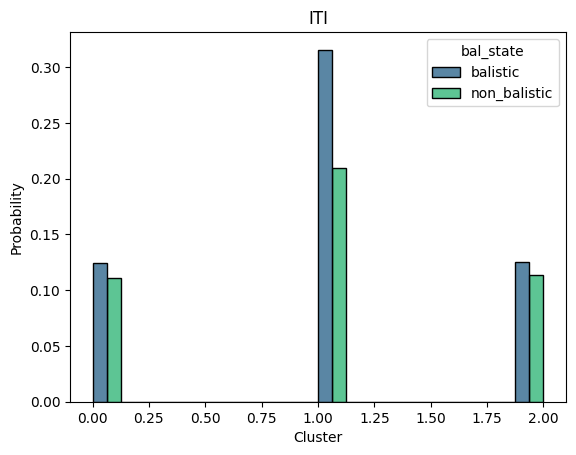

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


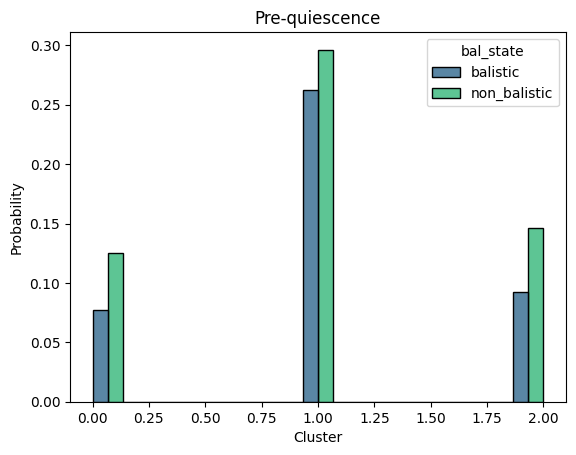

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


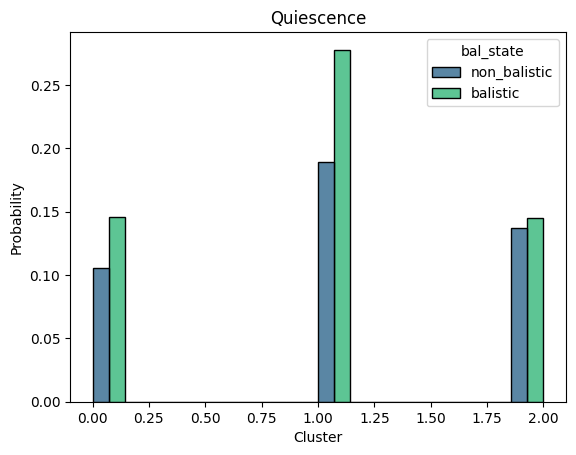

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


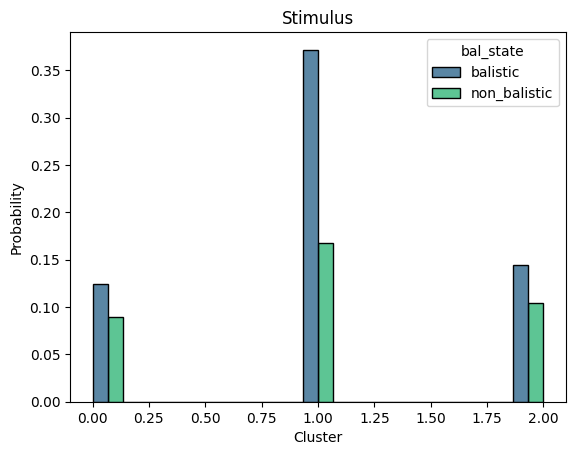

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    use_data = get_ballistic(use_data)
    sns.histplot(hue='bal_state', x='cluster', alpha=0.8,data=use_data, stat='probability', multiple='dodge', palette='viridis')
    plt.xlabel('Cluster')
    # plt.ylabel('Proportion ballistic')
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

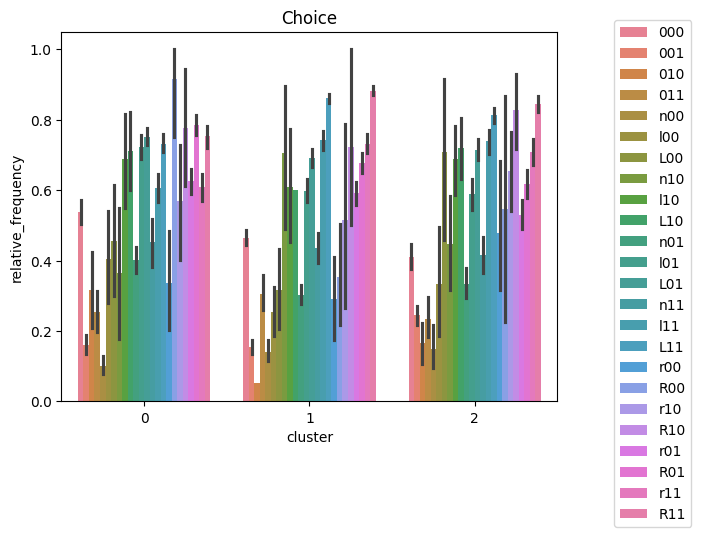

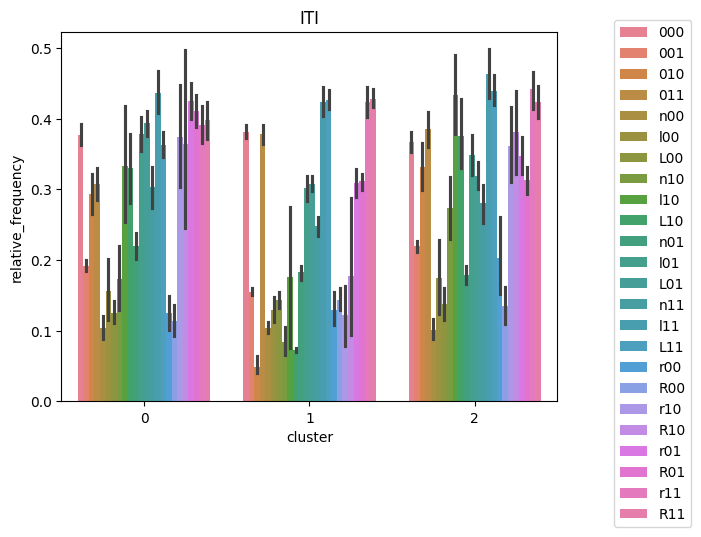

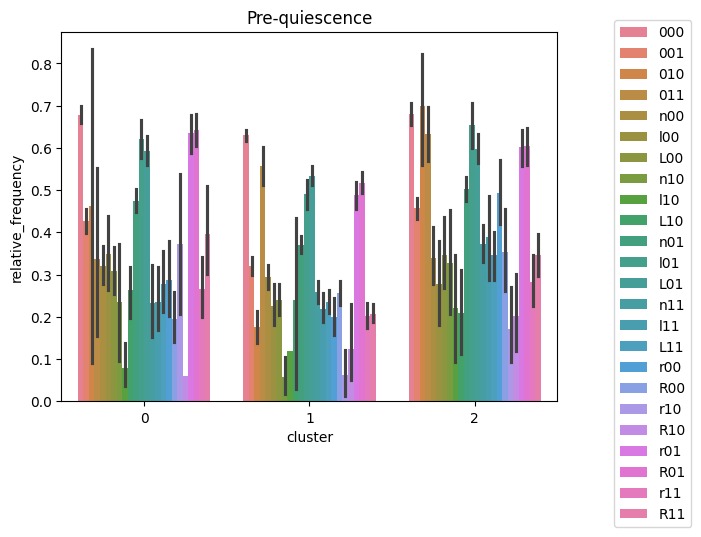

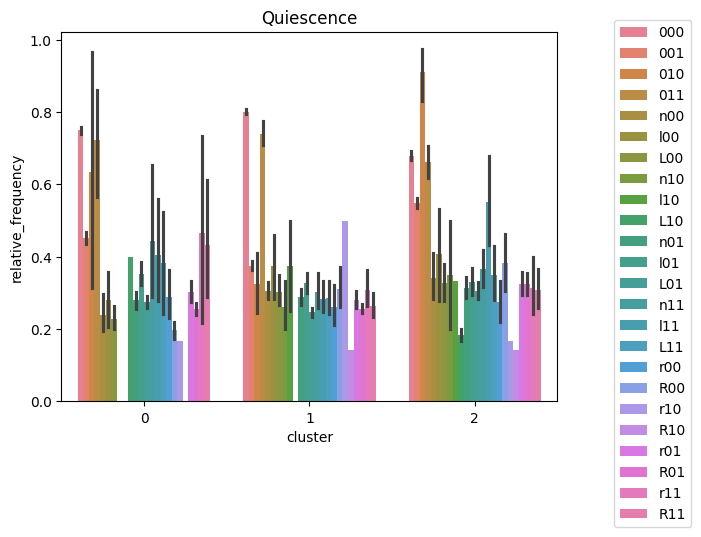

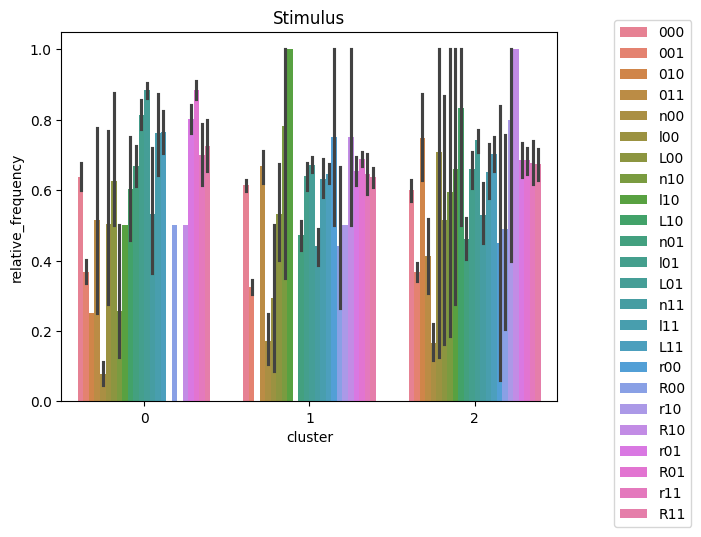

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='cluster', 
                hue_order = ['000', '001', '010', '011', 'n00', 'l00', 'L00',
                             'n10', 'l10', 'L10', 'n01', 'l01', 'L01', 'n11', 'l11', 'L11',
                             'r00', 'R00', 'r10', 'R10', 'r01', 'R01', 'r11', 'R11'
                             ], data=use_data)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


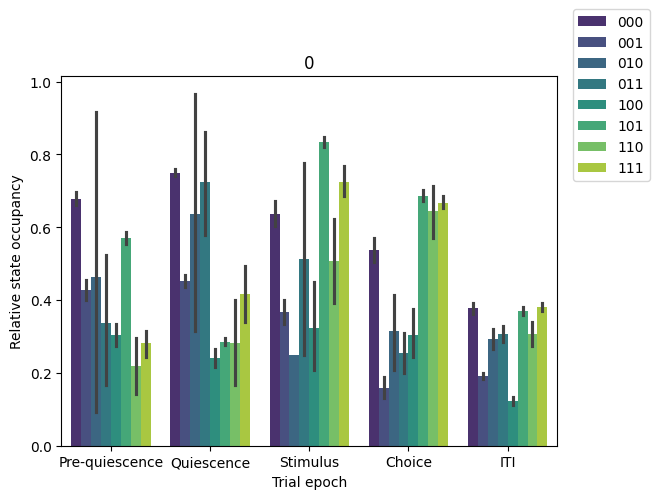

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


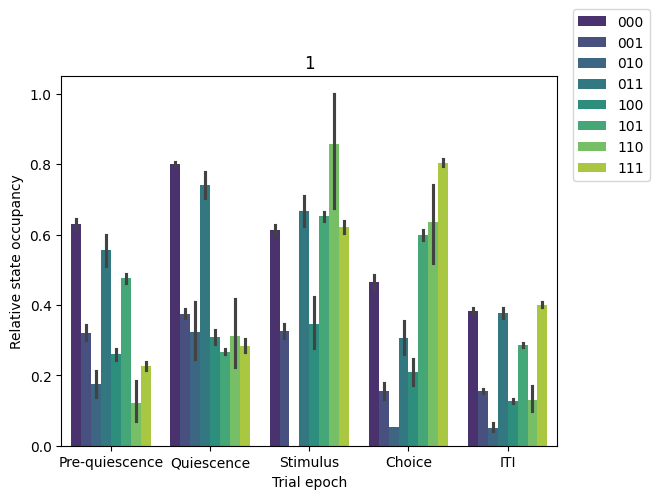

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


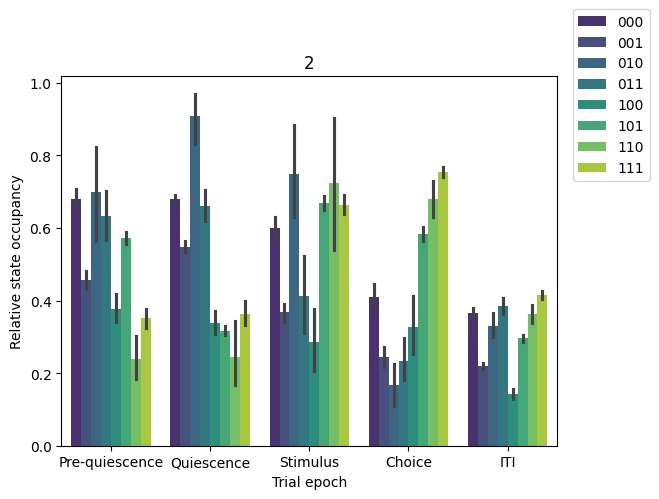

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


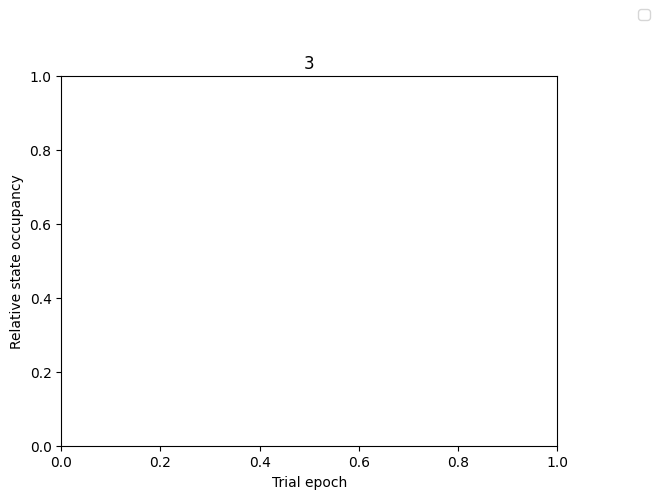

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


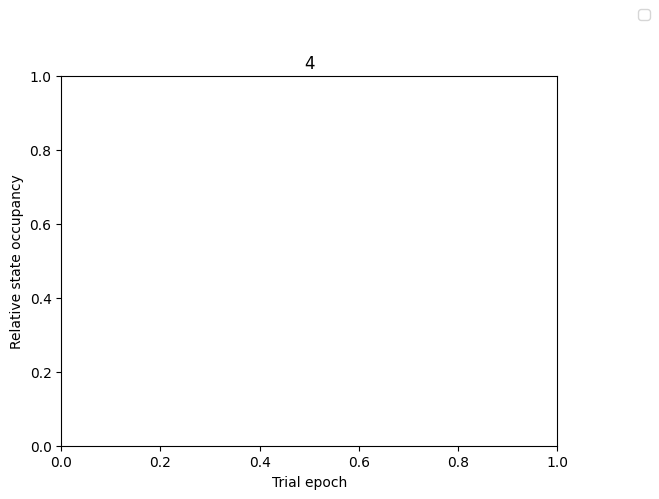

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


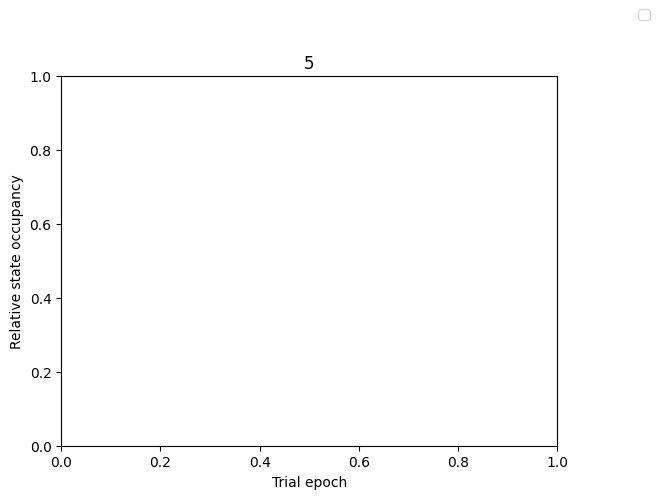

In [ ]:
for c, cluster in enumerate(range(6)):
    use_data = df_cluster.loc[df_cluster['cluster']==cluster]
    use_data = revert_to_original(use_data)
    sns.barplot(x='broader_label', y='relative_frequency', hue='original_states', 
                order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], 
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Trial epoch')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.2, 1.2))
    plt.title(cluster)
    plt.show()